In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

import utils
import model_spectra as NN
import fitting

import matplotlib.pyplot as plt
from matplotlib import gridspec
import corner
import ipywidgets as widgets
from ipywidgets import interact
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# Check label recovery 

In [3]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# read in all individual neural networks we'll need. 
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Generate a spectrum from labels and NN
feh = -2.0
alphafe = 0.0
alpha = alphafe + feh
Teff = 4100
logg = 0.5
RV = 0.0
real_labels = np.array([alphafe, alpha, alpha, alpha, alpha, alpha, alpha,
                        feh, Teff, logg, RV])
real_spec = NN.get_spectrum_from_neural_net(labels=real_labels, NN_coeffs=NN_coeffs)
label_names = ["[a/Fe]", "[Mg/H]", "[Si/H]", "[S/H]", "[Ar/H]", "[Ca/H]", "[Ti/H]",
               "[Fe/H]", "Teff", "logg", "RV"]
data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
spec_err = 0.01 * np.ones(len(wavelength))

# Apply Mask
mask = utils.restore_mask_from_file(name='008.0010337')
spec_err[mask] = 1e16
masked_wavelength = wavelength[mask]

# Fit spectrum
popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = None, num_p0 = 1)
std_err = np.sqrt(np.diag(pcov))

def plot1(xlim):
    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min = xlim[0]
    lambda_max = xlim[1]
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    
    #fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 8))
    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    ax1.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
    ax1.plot(wavelength[m], model_spec[m], 'r', lw=0.75, label = r'$\mathrm{Best-Fit\ Model}$')
    ax1.vlines(masked_wavelength, 0.70, 1.10, color='r', alpha=0.2)
    ax1.set_xlim(lambda_min, lambda_max)
    ax1.set_ylim(0.70,1.10)
    ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
    ax1.legend(loc = 'best', frameon = False, fontsize = 12)
    
    ax2.plot(wavelength[m], (data_spec[m]-model_spec[m])/data_spec[m], 'k', lw=0.5)
    ax2.hlines(0, lambda_min, lambda_max, linestyles='-.')
    ax2.vlines(masked_wavelength, -0.15, 0.15, color='r', alpha=0.2)
    ax2.set_xlim(lambda_min, lambda_max)
    ax2.set_ylim(-0.05,0.05)
    ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax2.set_ylabel(r'$\mathrm{\%\ Residuals}$')

    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.show()
interact(plot1, xlim=widgets.IntRangeSlider(min=6250,max=9500,step=50,value=[8400,8700]))

print('Best Fit Labels:\t True Labels:')
for i,label in enumerate(label_names):
    print('%s = %.2f+/-%.2f \t %s = %.2f' % (label, popt[i], std_err[i], label, real_labels[i]))

interactive(children=(IntRangeSlider(value=(8400, 8700), description='xlim', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:	 True Labels:
[a/Fe] = 0.02+/-0.10 	 [a/Fe] = 0.00
[Mg/H] = -2.00+/-0.25 	 [Mg/H] = -2.00
[Si/H] = -1.97+/-0.28 	 [Si/H] = -2.00
[S/H] = -1.95+/-0.25 	 [S/H] = -2.00
[Ar/H] = -2.01+/-0.26 	 [Ar/H] = -2.00
[Ca/H] = -1.98+/-0.26 	 [Ca/H] = -2.00
[Ti/H] = -2.00+/-0.28 	 [Ti/H] = -2.00
[Fe/H] = -2.01+/-0.15 	 [Fe/H] = -2.00
Teff = 4100.95+/-95.40 	 Teff = 4100.00
logg = 0.50+/-0.25 	 logg = 0.50
RV = -0.16+/-1.50 	 RV = 0.00


# Fitting Spectra from the Training Set

In [4]:
D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/synth_spectra/'
SpectraFile = 'convolved_synthetic_spectra_MIST.npz'
temp = np.load(SpectraDir + SpectraFile)
spectra = temp['spectra']
norm_spectra = temp['norm_spectra_approx']
labels = temp['labels']
temp.close()

Best Fit Labels:	 True Labels:
[a/Fe] = 0.01+/-0.10 	 [a/Fe] = 0.00
[Mg/H] = -2.01+/-0.25 	 [Mg/H] = -2.00
[Si/H] = -2.03+/-0.28 	 [Si/H] = -2.00
[S/H] = -1.99+/-0.25 	 [S/H] = -2.00
[Ar/H] = -2.00+/-0.26 	 [Ar/H] = -2.00
[Ca/H] = -1.97+/-0.26 	 [Ca/H] = -2.00
[Ti/H] = -2.01+/-0.28 	 [Ti/H] = -2.00
[Fe/H] = -1.99+/-0.15 	 [Fe/H] = -2.00
Teff = 4089.97+/-95.74 	 Teff = 4100.00
logg = 0.49+/-0.25 	 logg = 0.50
RV = -0.25+/-1.49 	 RV = 0.00


In [5]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# Restore NN
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Samples 10 spectra randomly from the training set
n = np.random.randint(0,len(norm_spectra),3)

for i, spec in enumerate(norm_spectra[n]):
    j = n[i]
    real_labels = np.append(labels[j],0.0)
    real_spec = spec
    data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
    spec_err = 0.01 * np.ones(len(real_spec))
    
    # Apply Mask
    mask = utils.generate_mask_from_file(name='008.0010337')
    spec_err[mask] = 1e16
    masked_wavelength = wavelength[mask]
    


    # Fit spectrum
    popt, pcov, model_spec \
        = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = None, num_p0 = 1)
    std_err = np.sqrt(np.diag(pcov))
    
    def plot2(xlim):
        # zoom in on a small region of the spectrum so we can see what's going on.
        lambda_min = xlim[0]
        lambda_max = xlim[1]
        m = (wavelength < lambda_max) & (wavelength > lambda_min)
        
        fig = plt.figure(figsize=(14, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        
        ax1.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
        ax1.plot(wavelength[m], model_spec[m], 'r', lw=0.75, label = r'$\mathrm{Best-Fit\ Model}$')
        ax1.vlines(masked_wavelength, 0.70, 1.10, color='r', alpha=0.2)
        ax1.set_xlim(lambda_min, lambda_max)
        ax1.set_ylim(0.70,1.10)
        ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
        ax1.legend(loc = 'best', frameon = False, fontsize = 12)
        
        ax2.plot(wavelength[m], (data_spec[m]-model_spec[m])/data_spec[m], 'k', lw=0.5)
        ax2.hlines(0, lambda_min, lambda_max, linestyles='-.')
        ax2.vlines(masked_wavelength, -0.15, 0.15, color='r', alpha=0.2)
        ax2.set_xlim(lambda_min, lambda_max)
        ax2.set_ylim(-0.05,0.05)
        ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
        ax2.set_ylabel(r'$\mathrm{\%\ Residuals}$')
        
        fig.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
        plt.show()
    interact(plot2, xlim=widgets.IntRangeSlider(min=6250,max=9500,step=50,value=[8400,8700]))
       
    print('Best Fit Labels:\t True Labels:')
    for i,label in enumerate(label_names):
        print('%s = %.2f+/-%.2f \t %s = %.2f' % (label, popt[i], std_err[i], label, real_labels[i]))

interactive(children=(IntRangeSlider(value=(8400, 8700), description='xlim', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:	 True Labels:
[a/Fe] = 0.99+/-0.04 	 [a/Fe] = 1.00
[Mg/H] = 0.94+/-0.16 	 [Mg/H] = 1.00
[Si/H] = 0.98+/-0.18 	 [Si/H] = 1.00
[S/H] = 1.00+/-0.16 	 [S/H] = 1.00
[Ar/H] = 0.99+/-0.17 	 [Ar/H] = 1.00
[Ca/H] = 0.98+/-0.16 	 [Ca/H] = 1.00
[Ti/H] = 0.98+/-0.18 	 [Ti/H] = 1.00
[Fe/H] = -0.00+/-0.05 	 [Fe/H] = 0.00
Teff = 4067.95+/-19.37 	 Teff = 4073.39
logg = 1.93+/-0.08 	 logg = 1.96
RV = 0.18+/-0.58 	 RV = 0.00


interactive(children=(IntRangeSlider(value=(8400, 8700), description='xlim', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:	 True Labels:
[a/Fe] = 0.05+/-0.13 	 [a/Fe] = 0.00
[Mg/H] = -1.42+/-0.30 	 [Mg/H] = -1.50
[Si/H] = -1.50+/-0.32 	 [Si/H] = -1.50
[S/H] = -1.45+/-0.30 	 [S/H] = -1.50
[Ar/H] = -1.55+/-0.30 	 [Ar/H] = -1.50
[Ca/H] = -1.41+/-0.31 	 [Ca/H] = -1.50
[Ti/H] = -1.42+/-0.32 	 [Ti/H] = -1.50
[Fe/H] = -1.49+/-0.19 	 [Fe/H] = -1.50
Teff = 4782.97+/-141.86 	 Teff = 4790.79
logg = 2.14+/-0.54 	 logg = 1.92
RV = -0.35+/-1.90 	 RV = 0.00


interactive(children=(IntRangeSlider(value=(8400, 8700), description='xlim', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:	 True Labels:
[a/Fe] = 0.78+/-0.08 	 [a/Fe] = 0.80
[Mg/H] = 0.05+/-0.23 	 [Mg/H] = 0.05
[Si/H] = 0.04+/-0.25 	 [Si/H] = 0.05
[S/H] = 0.03+/-0.24 	 [S/H] = 0.05
[Ar/H] = 0.04+/-0.24 	 [Ar/H] = 0.05
[Ca/H] = 0.10+/-0.24 	 [Ca/H] = 0.05
[Ti/H] = 0.02+/-0.26 	 [Ti/H] = 0.05
[Fe/H] = -0.72+/-0.12 	 [Fe/H] = -0.75
Teff = 4815.08+/-83.48 	 Teff = 4823.40
logg = 1.66+/-0.21 	 logg = 1.62
RV = -0.07+/-1.09 	 RV = 0.00


## Compare best fit labels with true labels

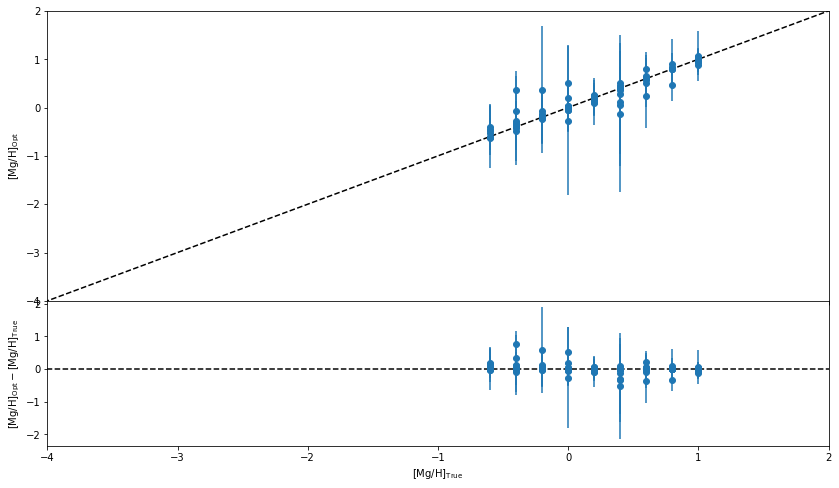

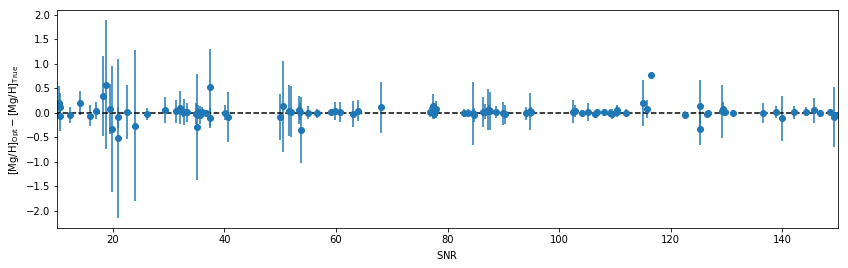

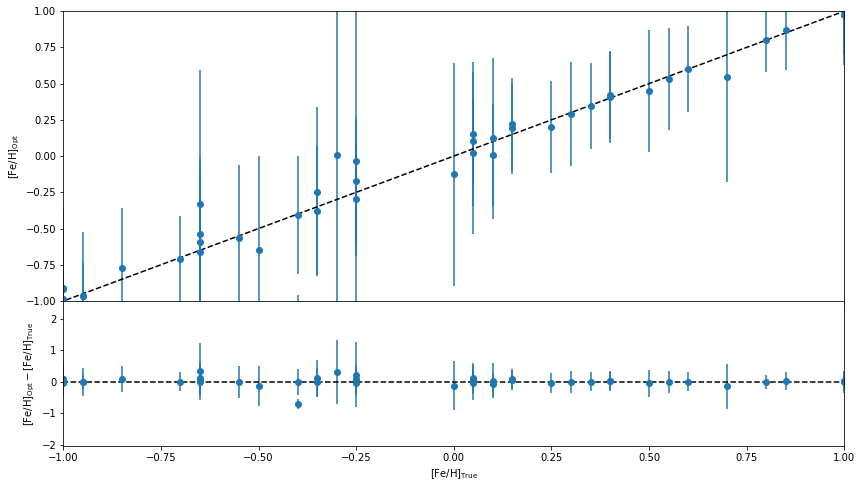

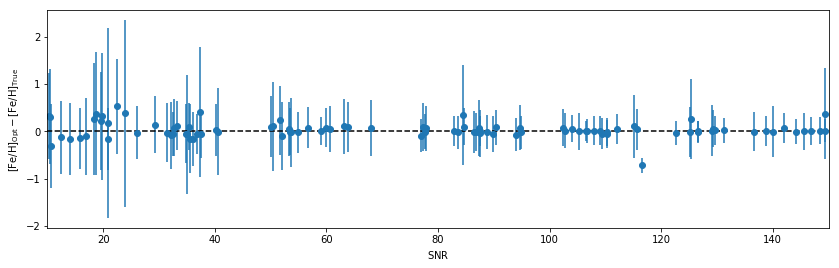

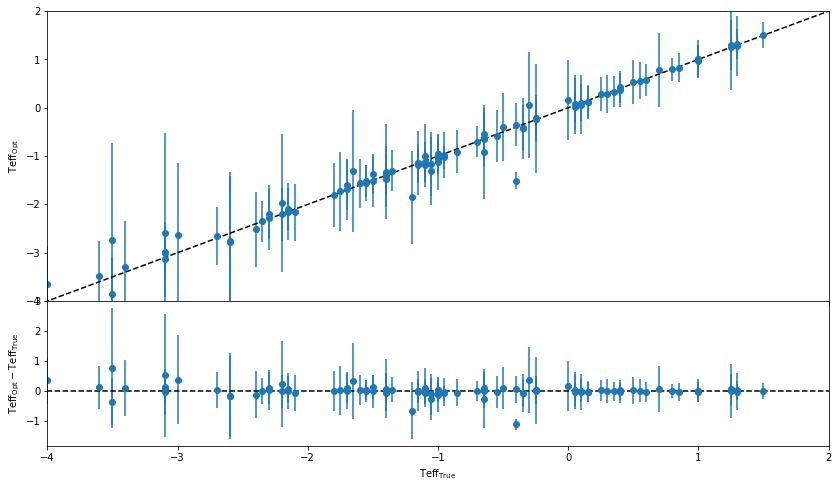

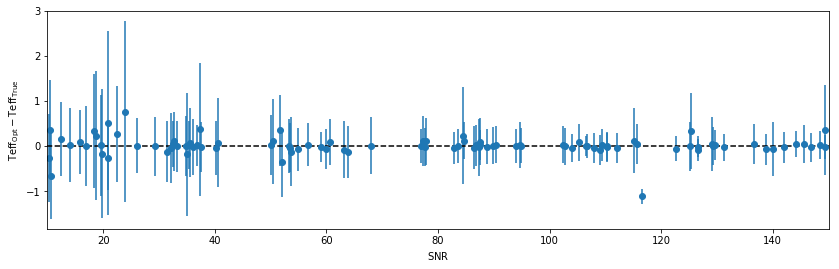

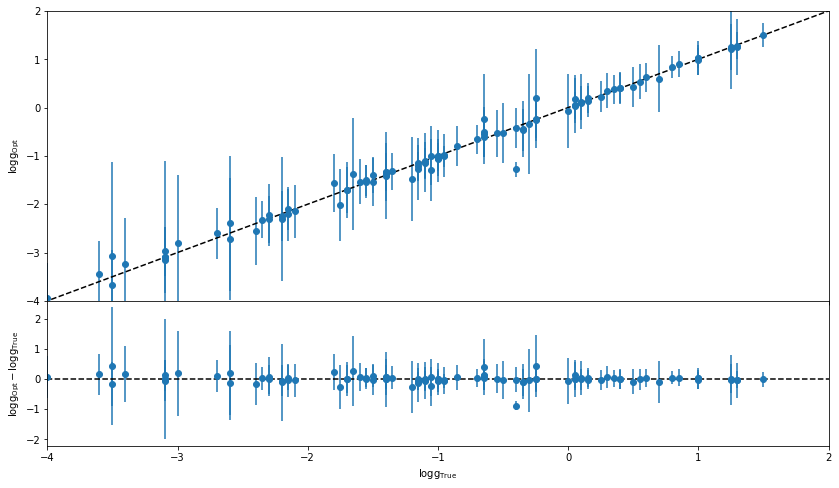

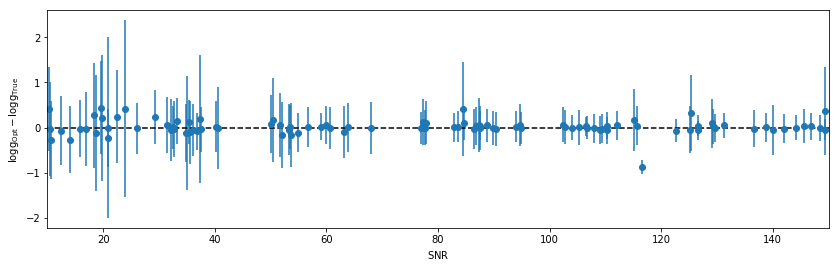

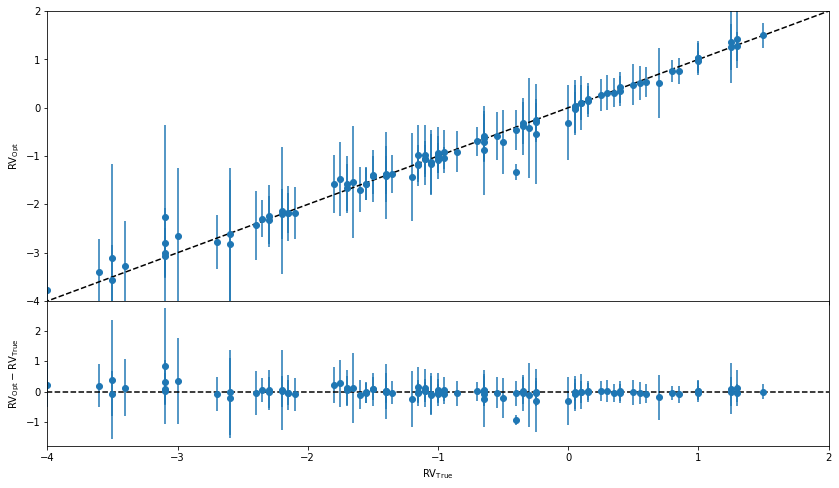

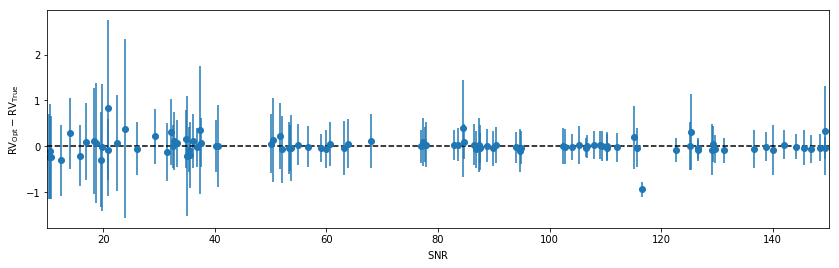

In [7]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# Restore NN
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Restore Training Spectra
D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/synth_spectra/'
SpectraFile = 'convolved_synthetic_spectra_MIST.npz'
temp = np.load(SpectraDir + SpectraFile)
spectra = temp['spectra']
norm_spectra = temp['norm_spectra_approx']
labels = temp['labels']
temp.close()

# Samples N spectra randomly from the training set
N = 100
n = np.random.randint(0,len(norm_spectra),N)
SNR = np.random.uniform(10, 150, N)
RV = np.random.uniform(-30,30,N)

# Initialize Lists
real_labels = np.empty((len(n), 11))
popt = np.empty((len(n), 11))
std_err = np.empty((len(n), 11))

for i, spec in enumerate(norm_spectra[n]):
    j = n[i]
    real_labels[i] = np.append(labels[j], RV[i])
    real_spec = utils.doppler_shift(wavelength, spec, RV[i])
    data_spec = real_spec + 1/SNR[i] * np.random.randn(len(real_spec))
    spec_err = 1/SNR[i] * np.ones(len(real_spec))
    
    # Apply Mask
    mask = utils.generate_mask_from_file(name='008.0010337')
    spec_err[mask] = 1e16
    masked_wavelength = wavelength[mask]

    # Fit spectrum
    popt[i], pcov, model_spec \
        = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = None, num_p0 = 1)
    std_err[i] = np.sqrt(np.diag(pcov))

label_names = np.array(["[a/Fe]", "[Mg/H]", "[Si/H]", "[S/H]", "[Ar/H]", "[Ca/H]", "[Ti/H]",
               "[Fe/H]", "Teff", "logg", "RV"])
label_mins = [-4, -1, -4, -4, -4, -4, -4, -4, 3500, 0.2, -30]
label_maxs = [2, 1, 2, 2, 2, 2, 2, 2, 10000, 5, 30]
for i, label in enumerate(label_names[[1,-4,-3,-2,-1]]):
    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    ax1.errorbar(real_labels[:,i], popt[:,i], yerr=std_err[:,i], fmt='o')
    ax1.plot((-100,30000),(-100,30000), ls='--', c='k')
    ax1.set_xlim(label_mins[i],label_maxs[i])
    ax1.set_ylim(label_mins[i],label_maxs[i])
    ax1.set_ylabel(r'$\mathrm{%s_{Opt}}$' % label)
    
    ax2.errorbar(real_labels[:,i], popt[:,i]-real_labels[:,i], yerr=std_err[:,i], fmt='o')
    ax2.plot((-100,30000),(0,0), ls='--', c='k')
    ax2.set_xlim(label_mins[i],label_maxs[i])
    ax2.set_xlabel(r'$\mathrm{%s_{True}}$' % label)
    ax2.set_ylabel(r'$\mathrm{%s_{Opt}-%s_{True}}$' % (label, label))

    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.show()
    
    fig = plt.figure(figsize=(14, 4))
    plt.errorbar(SNR, popt[:,i] - real_labels[:,i], yerr=std_err[:,i], fmt='o')
    plt.plot((-100,30000),(0,0), ls='--', c='k')
    plt.xlim(10, 150)
    plt.xlabel(r'$\mathrm{SNR}$')
    plt.ylabel(r'$\mathrm{%s_{Opt} - %s_{True}}$' % (label, label))
    plt.show()


# Fitting Real Spectra

In [ ]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# Restore NN
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Standard Stars
matches = [8, 26, 7, 40, 11]
feh = [0.33, -1.26, -0.06, -1.67, -1.6]
alpha = [0.23, -0.36, 0.06, 0.18, 0.47]
Teff = [5663.6, 5650.5, 4295.2, 5247., 4285.]
logg = [4.3, 3.64, 2.30, 3.14, 0.83]
RV = [0.0, 0.0, 0.0, 0.0, 0.0]
target = ['m15', 'm15', 'm71','m13', 'ngc7006']
standard = ['APOGEE', 'APOGEE', 'APOGEE', 'Kirby+ 2008', 'Kirby+ 2008']

# Initialize Lists
real_labels = np.empty((len(matches), 11))
popt = np.empty((len(matches), 11))
std_err = np.empty((len(matches), 11))
snr = np.empty((len(matches)))

for i, match in enumerate(matches):
    # Restore Observed Spectrum
    D_PayneDir = utils.D_PayneDir
    SpectraDir = D_PayneDir + 'spectra/obs_spectra/'
    SpectraFile = target[i]+'_Horne.npz'
    temp = np.load(SpectraDir + SpectraFile)
    obj = temp['obj']
    full_spectra = temp['spec']
    spectral_err = temp['spec_err']
    norm_spectra = temp['norm_spec']
    norm_spectral_err = temp['norm_spec_err']
    RA_Dec = SkyCoord(temp['RA_Dec'])
    temp.close()
    full_spec = full_spectra[match]
    spec_err = spectral_err[match]
    norm_spec = norm_spectra[match]
    norm_spec_err = norm_spectral_err[match]
    
    # Apply Mask
    mask = utils.generate_mask_from_file(name='008.0010337')
    norm_spec_err[mask] = 1e16
    masked_wavelength = wavelength[mask]
    
    # Initial Guess
    p0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5000., 4.0, 0.0])
    
    # Fit spectrum
    popt[i], pcov, model_spec \
        = fitting.fit_normalized_spectrum_single_star_model(norm_spec = norm_spec,
                                                            spec_err = norm_spec_err,
                                                            NN_coeffs = NN_coeffs,
                                                            p0 = p0, num_p0 = 10)
    std_err[i] = np.sqrt(np.diag(pcov))
    
    def plot3(xlim):
        # zoom in on a small region of the spectrum so we can see what's going on.
        lambda_min = xlim[0]
        lambda_max = xlim[1] 
        m = (wavelength < lambda_max) & (wavelength > lambda_min)
        
        fig = plt.figure(figsize=(14, 8))
        gs = gridspec.GridSpec(3, 1, height_ratios=[3,1,1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])
        
        ax1.plot(wavelength[m], norm_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
        ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = r'$\mathrm{Best-Fit\ Model}$')
        ax1.vlines(masked_wavelength, 0.60, 1.10, color='r', alpha=0.2)
        ax1.set_xlim(lambda_min, lambda_max)
        ax1.set_ylim(0.60,1.10)
        ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
        ax1.legend(loc = 'best', frameon = False, fontsize = 12)
        
        ax2.plot(wavelength[m], (norm_spec[m]-model_spec[m])/norm_spec[m], 'k', lw=0.5)
        ax2.vlines(masked_wavelength, -0.15, 0.15, color='r', alpha=0.2)
        ax2.hlines(0, lambda_min, lambda_max, linestyles='-')
        ax2.hlines(0.05, lambda_min, lambda_max, linestyles=':', color='b')
        ax2.hlines(-0.05, lambda_min, lambda_max, linestyles=':', color='b')
        ax2.set_xlim(lambda_min, lambda_max)
        ax2.set_ylim(-0.15,0.15)
        ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
        ax2.set_ylabel(r'$\mathrm{Residuals}$')
        
        SNR = full_spec[m]/np.sqrt(spec_err[m])
        snr[i] = np.mean(SNR)
        ax3.plot(wavelength[m], SNR, 'k', lw=0.5)
        ax3.vlines(masked_wavelength, np.min(SNR)-1, np.min(SNR)+1, color='r', alpha=0.2)
        ax3.set_xlim(lambda_min, lambda_max)
        ax3.set_ylim(np.min(SNR),np.max(SNR))
        ax3.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
        ax3.set_ylabel(r'$\mathrm{SNR}$')
        
        plt.suptitle('Obj: %s\n\
                     RA: %.5f Dec: %.5f' % (obj[match], RA_Dec[match].ra.deg, RA_Dec[match].dec.deg))
        
        fig.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
        plt.show()
    interact(plot3, xlim=widgets.IntRangeSlider(min=6250,max=9500,step=50,value=[8400,8700]))
    
    # Restore Ground Truth Labels
    label_names = ["[alpha/Fe]", "[Mg/H]", "[Si/H]", "[S/H]", "[Ar/H]", "[Ca/H]", "[Ti/H]",
               "[Fe/H]", "Teff", "logg", "RV"]
    if standard[i] == 'APOGEE':
        alphafe = alpha[i] - feh[i]
        real_labels[i] = np.array([alphafe, alpha[i], alpha[i], alpha[i], alpha[i], alpha[i], alpha[i],
                                feh[i], Teff[i], logg[i], RV[i]])
        label_names = ["[alpha/Fe]", "[Mg/H]", "[Si/H]", "[S/H]", "[Ar/H]", "[Ca/H]", "[Ti/H]",
               "[Fe/H]", "Teff", "logg", "RV"]
    elif standard[i] == 'Kirby+ 2008':
        alphafe = alpha[i]
        alpha[i] = alphafe + feh[i]
        real_labels[i] = np.array([alphafe, alpha[i], alpha[i], alpha[i], alpha[i], alpha[i], alpha[i],
                                feh[i], Teff[i], logg[i], RV[i]])
        label_names = ["[alpha/Fe]", "[Mg/H]", "[Si/H]", "[S/H]", "[Ar/H]", "[Ca/H]", "[Ti/H]",
               "[Fe/H]", "Teff", "logg", "RV"]
    
    print('Best Fit Labels:\t Ground Truth Labels:')
    for j, label in enumerate(label_names):
        print('%s = %.2f+/-%.2f \t %s = %.2f' % (label, popt[i][j], std_err[i][j], label, real_labels[i][j]))
        
        
        
label_names = np.array(["[a/Fe]", "[Mg/H]", "[Si/H]", "[S/H]", "[Ar/H]", "[Ca/H]", "[Ti/H]",
               "[Fe/H]", "Teff", "logg", "RV"])
label_mins = [-4, -4, -4, -4, -4, -4, -4, -4, 3500, 0.2, -30]
label_maxs = [2, 2, 2, 2, 2, 2, 2, 2, 10000, 5, 30]
for i, label in enumerate(label_names[[1,-4,-3,-2,-1]]):
    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    ax1.errorbar(real_labels[:,i], popt[:,i], yerr=std_err[:,i], fmt='o')
    ax1.plot((-100,30000),(-100,30000), ls='--', c='k')
    ax1.set_xlim(label_mins[i],label_maxs[i])
    ax1.set_ylim(label_mins[i],label_maxs[i])
    ax1.set_ylabel(r'$\mathrm{%s_{Opt}}$' % label)
    
    ax2.errorbar(real_labels[:,i], popt[:,i]-real_labels[:,i], yerr=std_err[:,i], fmt='o')
    ax2.plot((-100,30000),(0,0), ls='--', c='k')
    ax2.set_xlim(label_mins[i],label_maxs[i])
    ax2.set_xlabel(r'$\mathrm{%s_{True}}$' % label)
    ax2.set_ylabel(r'$\mathrm{%s_{Opt}-%s_{True}}$' % (label, label))

    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.show()
    
    fig = plt.figure(figsize=(14, 4))
    plt.errorbar(snr, popt[:,i] - real_labels[:,i], yerr=std_err[:,i], fmt='o')
    plt.plot((-100,30000),(0,0), ls='--', c='k')
    plt.xlim(50, 150)
    plt.xlabel(r'$\mathrm{SNR}$')
    plt.ylabel(r'$\mathrm{%s_{Opt} - %s_{True}}$' % (label, label))
    plt.show()
